# Neural networks for front-car selection

This jupyter notebook demonstrates how to train a neural network to enable front-car selection.

![title](img/frontcar.jpg)

As can be observed by the above figure, the input for front-car selection contains two parts:

* Bounding boxes of vehicles obtained from object recognition (red rectangle in the figure)
* Lane information characterized by points or parameters (e.g., green triangle in the figure)

The output of the network shall indicate the vehicle in the front, e.g., the red vehicle being sourounded by a blue rectangle.

One should observe that designing such a front-car selection can be a nontrivial task, as things such as area covering is not working - the box of the truck actually intersects a larger area with the triangle. Therefore, in this project, we train a neural network to perform required tasks. 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline



In [2]:
import numpy as np
import ast
import torch

# For repeatability
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
IMAGE_SIZE_X = 1800
IMAGE_SIZE_Y = 450
TARGET_LABEL_QUANTITY = 1

### Preparing the data

We now prepare a data processor for preparing data used in training. The input will be organized as a 2D numpy array with size being "(numberOfVehiclesBeingTracked + 1) x 4".

* For the first numberOfVehiclesBeingTracked elements, they are used to store bounding boxes. THerefore, this neural network only takes finitely many bounding boxes. 
* For the last element, it is used to store the 4 inputs of the lane detection algorithm.


![title](img/inputformat.jpg)


To have better performance, we want all data to be normalized to value between 0 and 1. Apart from dividing centerX with IMAGE_SIZE_X and dividing centerY with IMAGE_SIZE_Y, we have one additional processing step for normalizing the data, where we derive the largest bounding box size.

In [4]:
from torch.utils.data.dataset import Dataset

class TargetVehicleSelectionDataProcessor():
    
    numberOfVehiclesBeingTracked = 20
    numberOfOutputClasses = numberOfVehiclesBeingTracked + 1

    
    def __init__(self, vehicleFile, roadFile, targetVehicleFile):
        
        
        object_labels_file = open(vehicleFile, "r")

        maxQuantityBoxSize = 0
        filename = object_labels_file.readline()
    
        inputFeaturesList = []
        print("----- Read bounding box information to get max box (for normalization) -----")
        count = 0
        while filename:

            labels = ast.literal_eval(object_labels_file.readline())        

            # For the 1st axis, the items are object-exist(0,1), centerX, centerY, widthX, widthY
            for label in labels:
                if label[0] == "car" or label[0] == "truck":
                    widthX = label[2][2]
                    widthY = label[2][3]
                    if(maxQuantityBoxSize < widthX):
                        maxQuantityBoxSize = widthX
                    if(maxQuantityBoxSize < widthY):
                        maxQuantityBoxSize = widthY
            filename = object_labels_file.readline()
 

        print(maxQuantityBoxSize)
        print("----- Read road information to normalize coordinate (for normalization) -----")
        road_file = open(roadFile, "r")
       
        maxValue = [0,0,0,0,0,0,0]
        minValue = [IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X]

        while True:
            road = road_file.readline()
            if road == '':
                break
            laneMarkings = road.replace(",", " ").split()
            for i in [1,3,4,5]:
                # print(laneMarkings)
                if(float(laneMarkings[i]) < minValue[i]):
                    minValue[i] = float(laneMarkings[i])
                if(float(laneMarkings[i]) > maxValue[i]):
                    maxValue[i] = float(laneMarkings[i])
        
        
        minValueLane = [minValue[1], minValue[3], minValue[4], minValue[5]]
        maxValueLane = [maxValue[1], maxValue[3], maxValue[4], maxValue[5]]
        intervalLane = [0,0,0,0]
        for i in range(4):
            intervalLane[i] = maxValueLane[i] - minValueLane[i]
        print(minValueLane)
        print(maxValueLane)
        print(intervalLane)
        
        road_file.close()
        

        print("----- Read bounding box information & road segmation & target vehicle info to create input data -----")       
        object_labels_file = open(vehicleFile, "r")
        target_file = open(targetVehicleFile, "r")                
        road_file = open(roadFile, "r")

        
        # First read the image name
        object_labels = object_labels_file.readline()
        target = target_file.readline()
        
        # To store numpy input features
        inputFeaturesList = []
        # To store target vehicle class
        FinalSelectedVehicleList = []
        
        count = 0
        while object_labels:

            labels = ast.literal_eval(object_labels_file.readline())
            laneMarkings = road_file.readline().replace(",", " ").split()
            if(count % 10000 == 0):
                print(count)
            count = count + 1
            
            # For the 1st axis, the items are object-exist(0,1), centerX, centerY, widthX, widthY
            inputLabel = np.zeros([self.numberOfVehiclesBeingTracked + 1, 4])
            centerXList = []
            centerYList = [] 
            
            vehicleCount = 0
            for label in labels:
                if label[0] == "car" or label[0] == "truck":
                    
                    centerX = label[2][0] 
                    centerY = label[2][1]
                    # Normalize the value to be the maximum quantity of the box size
                    widthX = label[2][2] / maxQuantityBoxSize
                    widthY = label[2][3] / maxQuantityBoxSize                 
                    # Normalize the value by dividing it with the pixel
                    centerX = centerX / IMAGE_SIZE_X
                    centerY = centerY / IMAGE_SIZE_Y
                    centerXList.append(centerX)
                    centerYList.append(centerY)
                    
                    inputLabel[vehicleCount][0] = centerX
                    inputLabel[vehicleCount][1] = centerY
                    inputLabel[vehicleCount][2] = widthX
                    inputLabel[vehicleCount][3] = widthY
                    
                    vehicleCount = vehicleCount +1
                    
            inputLabel[self.numberOfVehiclesBeingTracked][0] = (float(laneMarkings[1]) - minValueLane[0])/ intervalLane[0]
            inputLabel[self.numberOfVehiclesBeingTracked][1] = (float(laneMarkings[3]) - minValueLane[1])/ intervalLane[1]
            inputLabel[self.numberOfVehiclesBeingTracked][2] = (float(laneMarkings[4]) - minValueLane[2])/ intervalLane[2]
            inputLabel[self.numberOfVehiclesBeingTracked][3] = (float(laneMarkings[5]) - minValueLane[3])/ intervalLane[3]

                    
            inputFeaturesList.append(inputLabel)
            # Read again the image name, in order to move on to the next one. 
            object_labels = object_labels_file.readline()
            
            
            
            
            # Read the target file
            labels = ast.literal_eval(target_file.readline())                                 
            targetLabel = np.zeros([self.numberOfOutputClasses]) # for L1 loss

            
            hasTarget = False
            if not (len(labels) == 0):
                if labels[0] == "car" or labels[0] == "truck":
                    centerX = labels[2][0] / IMAGE_SIZE_X
                    centerY = labels[2][1] / IMAGE_SIZE_Y

                    hasFound = False
                    for i in range(len(centerXList)):
                        if(centerXList[i] == centerX and centerYList[i] == centerY):
                            targetLabel[i] = TARGET_LABEL_QUANTITY                    
                            hasFound = True
                            break
                            
                    hasTarget = True
           
            if hasTarget == False:
                targetLabel[self.numberOfOutputClasses - 1] = TARGET_LABEL_QUANTITY
                
            FinalSelectedVehicleList.append(targetLabel)
            
            # Read again the target file, in order to move on to the next one. 
            filename = target_file.readline()
            
            
            
        self.inputFeatures = np.dstack(inputFeaturesList)
        self.inputFeatures = np.rollaxis(self.inputFeatures,-1)
        self.inputFeatures = torch.from_numpy(np.float32(self.inputFeatures))
        
        
        self.labels = np.dstack(FinalSelectedVehicleList)
        self.labels = np.rollaxis(self.labels,-1)
        self.labels = torch.from_numpy(np.float32(np.squeeze(self.labels, axis=1)))
  
        object_labels_file.close()
        road_file.close()        
        target_file.close()           


        if not(self.inputFeatures.shape[0] == self.labels.shape[0]):
            raise Error("Size of target vehicles not the same as size of inputs")

    def __len__(self):
        return self.inputFeatures.shape[0] # of how many examples(images?) you have            
    
    def dumpDataToNpy(self, fileName):
        np.save(fileName, self.inputFeatures.numpy())
        
    def dumpLabelToNpy(self, fileName):
        np.save(fileName, self.labels.numpy())


If you do not have the .npy file available, please set the variable processRawData to True. Also, prepare a "local" folder.

In [5]:
processRawData = False

if processRawData:
    dataset = TargetVehicleSelectionDataProcessor("data/batch_results_sorted.txt", "data/triangles_opencv_sorted.txt", "data/fw_label_sorted_v5.txt")
    dataset.dumpDataToNpy("local/batch_results_processed_nogrid.npy")
    dataset.dumpLabelToNpy("local/fw_label_processed_nogrid.npy")
    print("----- size of the data -----")
    print(len(dataset))
    

Then one can prepare dataset using the below class. The parameter "isL2Loss" is used to create output either as one hot encoding (as used in L1 loss) or as general numeric enocding (as used in L2 loss).

In [6]:
class TargetVehicleSelectionDataset(Dataset):
    
    inputFeatures = None
    labels = None
    
    def __init__(self, vehicleFileNpy, targetVehicleFileNpy, isL2Loss):     

        self.inputFeatures = torch.from_numpy(np.load(vehicleFileNpy))
        
        if isL2Loss:
            # Rewrite one-hot encoding back
            self.labels = torch.from_numpy(np.argmax(np.int64(np.load(targetVehicleFileNpy)), axis=1))
        else:
            self.labels = torch.from_numpy(np.load(targetVehicleFileNpy))
    
        
    def __getitem__(self, index):
        # stuff
        return (self.inputFeatures[index], self.labels[index])

    def __len__(self):
        return self.inputFeatures.shape[0] # of how many examples(images?) you have

In [7]:
dataset = TargetVehicleSelectionDataset("local/batch_results_processed_nogrid.npy", "local/fw_label_processed_nogrid.npy", True)
print(len(dataset))

123996


In [8]:
import torch.nn as nn
import torch.nn.functional as F

numberOfVehiclesBeingTracked = 20
numberOfOutputClasses = numberOfVehiclesBeingTracked + 1

class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear((numberOfVehiclesBeingTracked+1)*4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, numberOfOutputClasses)
        
    def forward(self, x):
        x = x.view(-1, (numberOfVehiclesBeingTracked+1)*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out 
  
    
net = NeuralNet()
net.eval()




NeuralNet(
  (fc1): Linear(in_features=84, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=21, bias=True)
)

In [9]:
# Loss and optimizer
learning_rate = 0.001
batch_size = 2048
num_epochs = 20


# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

# weight_decay as parameter to be tuned 0, 0.001, 0.01
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)  

In [10]:
net.load_state_dict(torch.load('models/model_front_car_100x50.ckpt'))

We resere 5% for validation set (for hyper parameter tuning), 5% for test set (never touch it), and 90% for training

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

test_size = 0.05

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(test_size * num_train))

np.random.shuffle(indices)

train_idx, valid_idx, test_idx = indices[(2*split):], indices[split:(2*split)], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=train_sampler,
                                           batch_size=batch_size)

valid_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=valid_sampler,
                                           batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=test_sampler,
                                          batch_size=batch_size)

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

furtherTrain = False

if furtherTrain: 
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            if batch_size > 5000:
                if (i+1) % 4 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))    
            elif batch_size > 1000:
                if (i+1) % 10 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))           
            else: 
                if (i+1) % 1000 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))              


In [13]:
# In test phase, we don't need to compute gradients (for memory efficiency)

isL2Loss = True

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        #print(images[0])
        outputs = net(images)
        _, predictedY = torch.max(outputs.data, 1)
        
        correctLabelsY = None        
        if(isL2Loss):
            # L2 (without one-hot encoding)
            correctLabelsY = labels.data            
        else:
            # L1 (with one-hot encoding)
            _, correctLabelsY = torch.max(labels.data, 1)

        
        total += labels.size(0)
        
        # print(labels.numpy().shape)
        correct += (predictedY == correctLabelsY).sum().item()
        

    print('Accuracy of the network on the training set: {} %'.format(100 * correct / total))
     
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predictedY = torch.max(outputs.data, 1)
        
        correctLabelsY = None        
        if(isL2Loss):
            # L2 (without one-hot encoding)
            correctLabelsY = labels.data            
        else:
            # L1 (with one-hot encoding)
            _, correctLabelsY = torch.max(labels.data, 1)
        
        total += labels.size(0)
        
        # print(labels.numpy().shape)
        correct += (predictedY == correctLabelsY).sum().item()
        

    print('Accuracy of the network on the validation set: {} %'.format(100 * correct / total))
    

Accuracy of the network on the training set: 85.79096399577054 %
Accuracy of the network on the validation set: 85.2879496693015 %


In [14]:
# torch.save(net.state_dict(), 'models/model_front_car_100x50.ckpt')

## Test the front-car selection network on images

Here we provide two utility functions 
* derivePredictedFrontCar() for deriving the index of the bounding box to be front car
* drawFrontCar() for drawing the front car in the image

In [15]:
def derivePredictedFrontCar(boundingBoxList, laneDetectionInfo):
    '''
    Derive which box is the front vehicle. 
    
    Args:
    boundingBoxList -- a list of bounding boxes (represented as an array [centerX, centerY, sizeX, sizeY]) representing vehicles (other objects such as signs shall be removed)
    laneDetectionInfo -- a list of 4 inputs [x1, x2, y2, x3]
    
    Returns:
    int: index of boundingBoxList if one of them is a predicted front car, -1 if no car is detected
    '''
    
    # Parameters here are derived by analyzing the data
    maxQuantityBoxSize = 1984.615966796875
    minValueLane = [268.0, 708.0, 7.0, 954.0]
    intervalLane = [569.0, 409.0, 292.0, 602.0]
    numberOfVehiclesBeingTracked = 20
    numberOfOutputClasses = numberOfVehiclesBeingTracked + 1    
    
    inputLabel = np.zeros([numberOfVehiclesBeingTracked + 1, 4])
    
    vehicleCount = 0
    for boundingBox in boundingBoxList:
        centerX = boundingBox[0] 
        centerY = boundingBox[1]
        # Normalize the value to be the maximum quantity of the box size
        widthX = boundingBox[2] / maxQuantityBoxSize
        widthY = boundingBox[3] / maxQuantityBoxSize                 

        
        # Normalize the value by dividing it with the pixel
        centerX = centerX / IMAGE_SIZE_X
        centerY = centerY / IMAGE_SIZE_Y

        inputLabel[vehicleCount][0] = centerX
        inputLabel[vehicleCount][1] = centerY
        inputLabel[vehicleCount][2] = widthX
        inputLabel[vehicleCount][3] = widthY
        vehicleCount = vehicleCount + 1
        inputLabel[numberOfVehiclesBeingTracked][0] = (float(laneDetectionInfo[0]) - minValueLane[0])/ intervalLane[0]
        inputLabel[numberOfVehiclesBeingTracked][1] = (float(laneDetectionInfo[1]) - minValueLane[1])/ intervalLane[1]
        inputLabel[numberOfVehiclesBeingTracked][2] = (float(laneDetectionInfo[2]) - minValueLane[2])/ intervalLane[2]
        inputLabel[numberOfVehiclesBeingTracked][3] = (float(laneDetectionInfo[3]) - minValueLane[3])/ intervalLane[3]
        

    inputs = []
    inputs.append(inputLabel)         
    inputs = np.dstack(inputs)
    inputs = np.rollaxis(inputs,-1)
    inputs = torch.from_numpy(np.float32(inputs))

    with torch.no_grad():
        
        # print(inputs[0])
        
        inputs = inputs.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)    

        output = predicted.numpy()[0]
        
        if(output == numberOfOutputClasses - 1):
            print("network says that no front car")
            return -1
        else:
            return output


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


def drawFrontCar(imgFile, boundingBox):
    im = np.array(Image.open(imgFile), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    rect = patches.Rectangle((int(boundingBox[0]-boundingBox[2]/2),int(boundingBox[1]-boundingBox[3]/2)),int(boundingBox[2]),int(boundingBox[3]),linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

#### A. Image frames0023291.jpg

(1) Input from the bounding box

[('car', 0.9984562397003174, (576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938)), 
('car', 0.9743680953979492, (127.26703643798828, 286.13848876953125, 252.41139221191406, 164.10342407226562)), 
('car', 0.8326014876365662, (781.6996459960938, 238.186279296875, 42.52123260498047, 26.923107147216797)), 
('car', 0.8239439129829407, (845.2855834960938, 235.84620666503906, 41.73268127441406, 35.90092468261719)), 
('car', 0.6865452527999878, (975.0291137695312, 240.38128662109375, 67.97051239013672, 43.96461868286133)), 
('car', 0.6862249374389648, (699.9054565429688, 240.95892333984375, 52.11764907836914, 34.9674186706543)), 
('car', 0.5572288036346436, (888.8295288085938, 233.42330932617188, 25.159809112548828, 25.35500144958496))]

(2) Input from the lane info: (frames0023291: 372,450 853,185 1186,450)


(3) Correct result of frames0023291.jpg (as ground truth):
('car', 0.9984562397003174, (576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938))

<!--- ![title](img/sequence/test/frames0023291.jpg) -->

In [17]:
boundingBoxList=[[576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938], 
                [127.26703643798828, 286.13848876953125, 252.41139221191406, 164.10342407226562],
                [781.6996459960938, 238.186279296875, 42.52123260498047, 26.923107147216797],
                [845.2855834960938, 235.84620666503906, 41.73268127441406, 35.90092468261719],
                [975.0291137695312, 240.38128662109375, 67.97051239013672, 43.96461868286133],
                [699.9054565429688, 240.95892333984375, 52.11764907836914, 34.9674186706543],
                [888.8295288085938, 233.42330932617188, 25.159809112548828, 25.35500144958496]]

laneDetectionInfo=[372,853,185,1186]

In [18]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

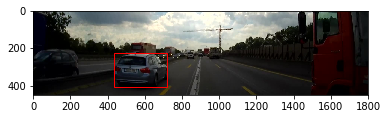

In [19]:
if index != -1:
    drawFrontCar('img/sequence/test/frames0023291.jpg', boundingBoxList[index])

#### B. Image frames0060931.jpg

(1) Input from the bounding box

[('truck', 0.9686129093170166, (664.022216796875, 176.36538696289062, 238.4475555419922, 192.21405029296875)), 
('truck', 0.8795585036277771, (1045.208251953125, 200.95474243164062, 127.88365173339844, 149.4367218017578)), 
('car', 0.8282604217529297, (881.839111328125, 175.23509216308594, 29.620193481445312, 24.062349319458008)), 
('car', 0.7414387464523315, (806.3452758789062, 178.2257080078125, 46.19411849975586, 32.87610626220703)), 
('car', 0.6790100336074829, (916.25244140625, 170.0439453125, 17.430356979370117, 15.947772979736328))]

(2) Input from the lane info: (frames0060931: 489,450 927,180 1202,450)

(3) Correct result of frames0060931.jpg:
() 


<!---  ![title](img/sequence/test/frames0060931.jpg) -->

In [20]:

boundingBoxList=[[664.022216796875, 176.36538696289062, 238.4475555419922, 192.21405029296875], 
                [1045.208251953125, 200.95474243164062, 127.88365173339844, 149.4367218017578],
                [881.839111328125, 175.23509216308594, 29.620193481445312, 24.062349319458008],
                [806.3452758789062, 178.2257080078125, 46.19411849975586, 32.87610626220703],
                [916.25244140625, 170.0439453125, 17.430356979370117, 15.947772979736328]]

laneDetectionInfo=[372,853,185,1186]

In [21]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

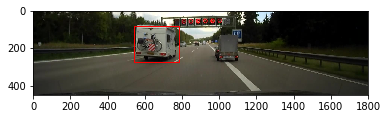

In [22]:
if index != -1:
    drawFrontCar('img/sequence/test/frames0060931.jpg', boundingBoxList[index])

#### C. Image frames0061374.jpg

(1) Input from the bounding box

[('truck', 0.7765164971351624, (912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297)), 
('car', 0.5375076532363892, (819.02392578125, 178.01235961914062, 35.7996940612793, 28.5452823638916))]


(2) Input from the lane info: (frames0061374: 496,450 912,165 1264,450)


(3) Correct result of frames0061374.jpg:
('truck', 0.7765164971351624, (912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297))

<!--- ![title](img/sequence/test/frames0061374.jpg) -->

In [23]:
boundingBoxList=[[912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297], 
                [819.02392578125, 178.01235961914062, 35.7996940612793, 28.5452823638916]]

laneDetectionInfo=[496,912,165, 1264]

In [24]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

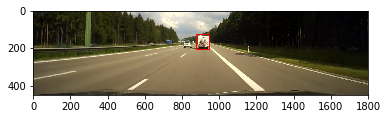

In [25]:
if index != -1:
    drawFrontCar('img/sequence/test/frames0061374.jpg', boundingBoxList[index])

# Formal verification

To run formal verification, it is required to install pulp (https://github.com/coin-or/pulp), which contains CBC MILP solver binding. 

In [26]:
for name, param in net.named_parameters():
    print(name)
    print(param.shape)


fc1.weight
torch.Size([100, 84])
fc1.bias
torch.Size([100])
fc2.weight
torch.Size([50, 100])
fc2.bias
torch.Size([50])
fc3.weight
torch.Size([21, 50])
fc3.bias
torch.Size([21])


In [27]:
net.eval()

NeuralNet(
  (fc1): Linear(in_features=84, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=21, bias=True)
)

<!-- ![title](img/encodingBigM.png) -->

### A. Dataflow analysis (with box domain)

Now we trigger dataflow analysis (i.e., abstract interpretation with box abstraction), which computes a sound [min.max] value for each neuron output, based on the assumption that the input is bounded. 

In [28]:
from nndependability.formal import dataflow 

minBound = dict()
maxBound = dict()

minBound[0] = np.zeros((numberOfVehiclesBeingTracked+1)*4)
maxBound[0] = np.ones((numberOfVehiclesBeingTracked+1)*4)

# Select an M value that is just large - internally the solver does mixed-integer-linear-programming to derive
bigM = 300.0
layerIndex = 1
weights = None
bias = None

for name, param in net.named_parameters():
    if name.endswith(".weight"):
        weights = param.detach().numpy()
    elif name.endswith(".bias"):
        # The weights are already available
        bias = param.detach().numpy()
        numberOfOutputs = weights.shape[0]
        numberOfInputs = weights.shape[1]

        minBound[layerIndex] = np.zeros(numberOfOutputs)
        maxBound[layerIndex] = np.zeros(numberOfOutputs)

        if(name.startswith("fc3")):                
            for i in range(numberOfOutputs):
                # print (str(layerIndex) + "  "+str(i))
                minBound[layerIndex][i] = dataflow.deriveLinearOutputBound(False, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1], [])
                maxBound[layerIndex][i] = dataflow.deriveLinearOutputBound(True, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1], [])        
        else:        
            for i in range(numberOfOutputs):
                # print (str(layerIndex) + "  "+str(i))
                minBound[layerIndex][i] = dataflow.deriveReLuOutputBound(False, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1])
                maxBound[layerIndex][i] = dataflow.deriveReLuOutputBound(True, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1])        
        
        layerIndex = layerIndex + 1
        
        # Reset the value to none
        weights = None
        bias = None
        

In [29]:
print("Dataflow analysis (boxed abstraction) over the bound of each neuron (layer 0: input):")
print("Min:")
print(minBound)
print("Max:")
print(maxBound)

Dataflow analysis (boxed abstraction) over the bound of each neuron (layer 0: input):
Min:
{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

### B. Dataflow analysis (with octagon domain)

After we perform dataflow analysis over the box domain, we can further do analysis on the octagon domain. In the octagon domain, one additionally keeps the min and max value of v1-v2. Therefore, if there are n neurons in the layer, there will be n(n-1)/2 such entries, meaning that MILP shall be triggered in frequency square to the number of neurons.  


In [30]:
from nndependability.formal import dataflow 
from nndependability.formal import octagon 

weights = None
bias = None
layerIndex = 1

octagonBound = dict()
octagonBound[0] = []

for name, param in net.named_parameters():
    if name.endswith(".weight"):
        weights = param.detach().numpy()
    elif name.endswith(".bias"):
        # The weights are already available
        
        print("Layer "+str(layerIndex) +": start")
        bias = param.detach().numpy()
        numberOfOutputs = weights.shape[0]
        numberOfInputs = weights.shape[1]

        octagonBound[layerIndex] = []

        if(name.startswith("fc3") == False):        
            for i in range(numberOfOutputs):
                print("\t["+str(i)+"]: ", end='')
                for j in range(numberOfOutputs):
                    if (j>i):
                        print(str(j)+"," , end='')
                        octagonconstraint = []

                        minimumValue = octagon.deriveReLuOutputDifferenceBound(False, layerIndex, weights, bias, numberOfInputs, i, j, bigM, minBound[layerIndex -1], maxBound[layerIndex -1], octagonBound[layerIndex -1])
                        vari = "v_"+str(layerIndex)+"_"+str(i)
                        varj = "v_"+str(layerIndex)+"_"+str(j)
                        maximumValue = octagon.deriveReLuOutputDifferenceBound(True, layerIndex, weights, bias, numberOfInputs, i, j, bigM,  minBound[layerIndex -1], maxBound[layerIndex -1], octagonBound[layerIndex -1])        

                        octagonconstraint = [minimumValue, vari, varj, maximumValue]
                        octagonBound[layerIndex].append(octagonconstraint)
                print()
        print("Layer "+str(layerIndex) +": completed")
        print()
        layerIndex = layerIndex + 1        
        # Reset the value to none
        weights = None
        bias = None
        


Layer 1: start
	[0]: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[1]: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[2]: 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[3]: 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,3

	[31]: 32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[32]: 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[33]: 34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[34]: 35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
	[35]: 36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,9

	[4]: 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[5]: 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[6]: 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[7]: 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[8]: 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[9]: 10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[10]: 11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
	[11]: 12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,3

We now compare the bound computed by the box abstraction and the octogon abstraction

In [31]:
print("===== Output bound based on boxed abstraction =====")
print("Min:")
print(minBound[3])
print("Max:")
print(maxBound[3])

===== Output bound based on boxed abstraction =====
Min:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max:
[222.92987 230.03752 276.45863 322.64416 238.05779 221.49117 204.65124
 255.84875 166.85402 178.08737 189.37235 228.03162 166.17096 165.43955
 210.15405 108.03387 103.80944   0.        0.        0.      164.22267]


We run dataflow analysis with this time adding octagon constraints

In [35]:
from nndependability.formal import dataflow 
from nndependability.formal import octagon 

minBoundOctagon = np.zeros(21)
maxBoundOctagon = np.zeros(21)

weights = None
bias = None
layerIndex = 0

for name, param in net.named_parameters():
    if name.endswith(".weight"):
        weights = param.detach().numpy()
    elif name.endswith(".bias"):
        # The weights are already available
        bias = param.detach().numpy()
        numberOfOutputs = weights.shape[0]
        numberOfInputs = weights.shape[1]

        if(name.startswith("fc3")):                
            for i in range(numberOfOutputs):
                print (str(layerIndex) + "  "+str(i))
                minBoundOctagon[i] = dataflow.deriveLinearOutputBound(False, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1], octagonBound[layerIndex -1])
                maxBoundOctagon[i] = dataflow.deriveLinearOutputBound(True, layerIndex, weights[i], bias[i], numberOfInputs, bigM, i, minBound[layerIndex -1], maxBound[layerIndex -1], octagonBound[layerIndex -1])        
        
        layerIndex = layerIndex + 1
        
        # Reset the value to none
        weights = None
        bias = None

2  0
2  1
2  2
2  3
2  4
2  5
2  6
2  7
2  8
2  9
2  10
2  11
2  12
2  13
2  14
2  15
2  16
2  17
2  18
2  19
2  20


In [36]:
print("===== Output bound based on octagon abstraction =====")
print("Min:")
print(minBoundOctagon)
print("Max:")
print(maxBoundOctagon)

===== Output bound based on octagon abstraction =====
Min:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max:
[64.916657 56.541592 79.60094  76.791589 76.742608 46.487268 78.528888
 88.384414 43.038181 60.47744  66.360891 60.099994 51.441014 55.975669
 78.465452 51.303454 38.961134  0.        0.        0.       49.684467]


We can observe that using Octagon abstraction domain, the output bound is indeed more precise.